In [8]:
import numpy as np
import pandas as pd

In [9]:
# Read the CSV file
hsg = pd.read_csv(r'C:\Documents\PTTK\Project\HSG Historical Data.csv')

hsg = hsg.sort_index(ascending=False)
hsg = hsg.reset_index(drop=True)
hsg['Date'] = pd.to_datetime(hsg['Date'])
hsg.set_index('Date', inplace=True)

# Modify data
# Remove the '%' sign and convert to float
hsg['Change %'] = hsg['Change %'].replace('%', '', regex=True).astype(float)

# Convert the percentage values to decimals (divide by 100)
hsg['Change %'] = hsg['Change %'] / 100

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    hsg[col] = hsg[col].str.replace(',', '').astype(float)

missing_values = hsg.isnull().sum()
hsg = hsg.dropna()

# Function to convert 'K' values to integers
def convert_volume(value):
    if pd.isnull(value):
        return np.nan  # Handle missing values
    elif 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    elif 'B' in value:
        return float(value.replace('B', '')) * 1000000000
    else:
        return float(value)

# Apply the function to the "Volume" column
hsg['Vol.'] = hsg['Vol.'].apply(convert_volume)

# Display the cleaned DataFrame
data = hsg[['Price']]
data

,Price
Date,
2020-01-02,5909.1
2020-01-03,5757.6
2020-01-06,5786.4
2020-01-07,5721.5
2020-01-08,5678.2
...,...
2024-10-28,20750.0
2024-10-29,20700.0
2024-10-30,20350.0


In [10]:
r_t = np.log(data['Price'] / data['Price'].shift(1)).dropna().values

In [11]:
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

array([ 0.00101923,  0.00498962, -0.01127933, -0.00759673,  0.02756555])

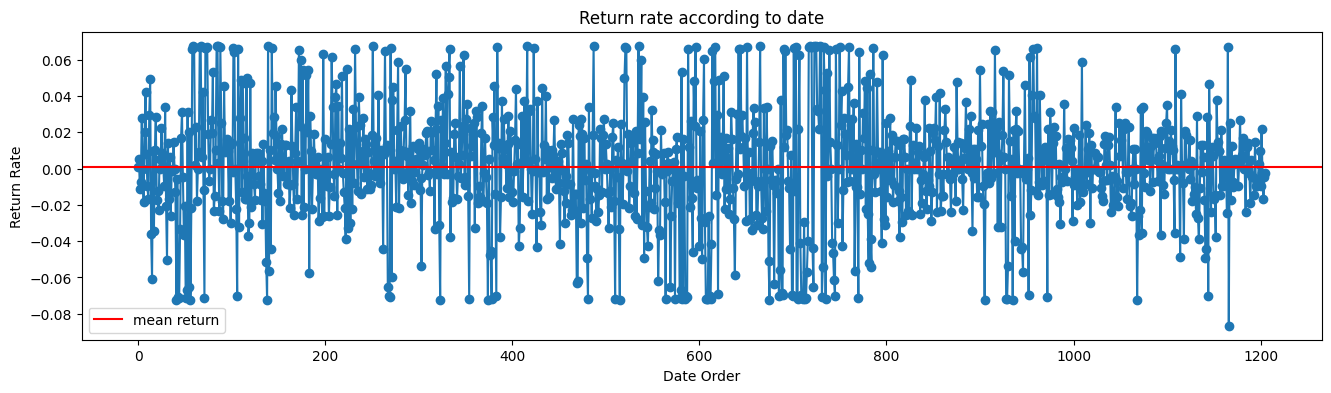

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.plot(np.arange(r_t.shape[0]), r_t, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

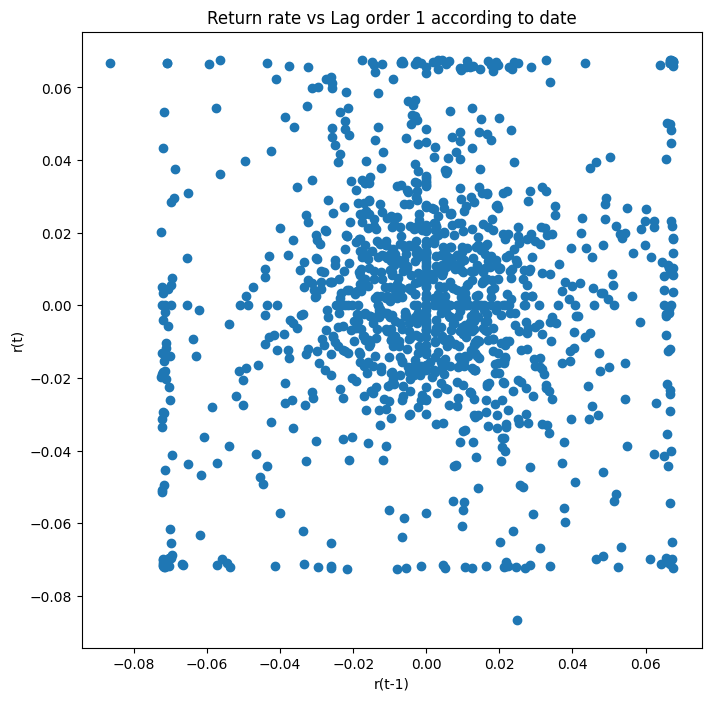

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

C:\Users\hien0\AppData\Local\Temp\ipykernel_7672\1195509066.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(r_t, bins = 20)


Text(0, 0.5, 'frequency')

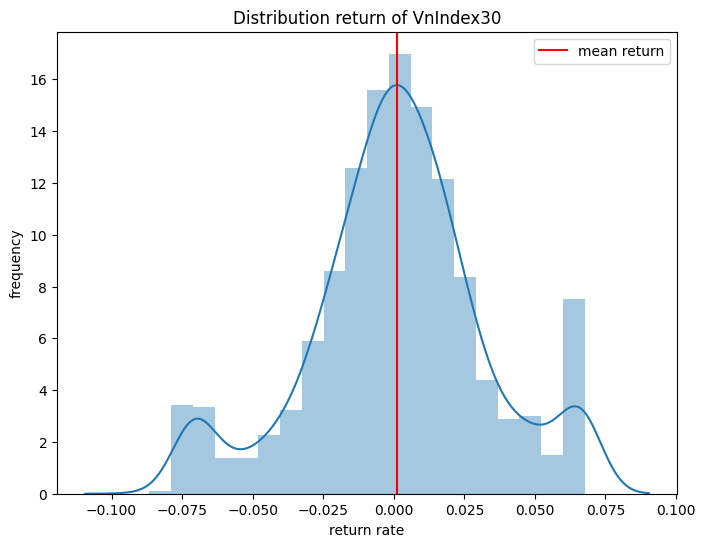

In [14]:
import seaborn as sns

plt.figure(figsize = (8, 6))
sns.distplot(r_t, bins = 20)
plt.axvline(x=mean, label='mean return', c='red')
plt.title('Distribution return of VnIndex30')
plt.legend()
plt.xlabel('return rate')
plt.ylabel('frequency')

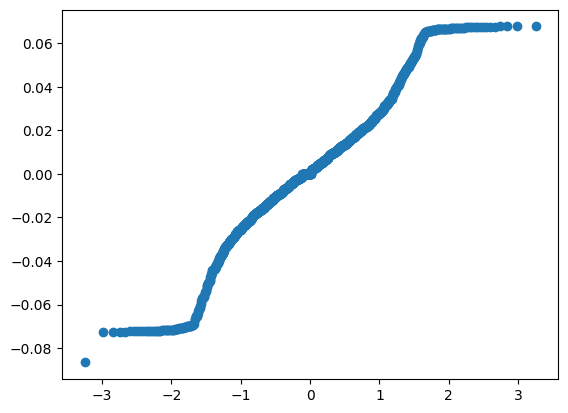

In [15]:
from scipy import stats
tq = stats.probplot(r_t)
plt.scatter(x=tq[0][0], y = tq[0][1])
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -32.379468
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


<Figure size 800x600 with 0 Axes>

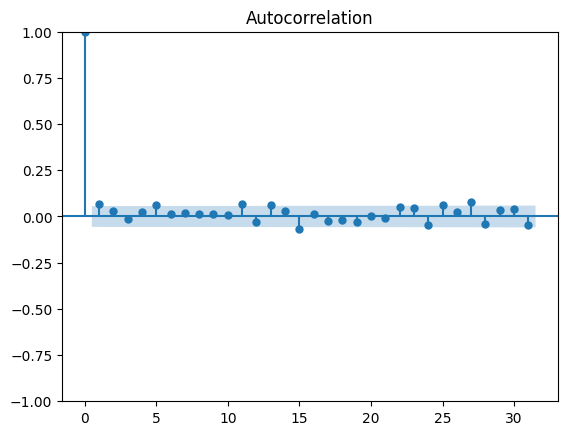

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)

<Figure size 800x600 with 0 Axes>

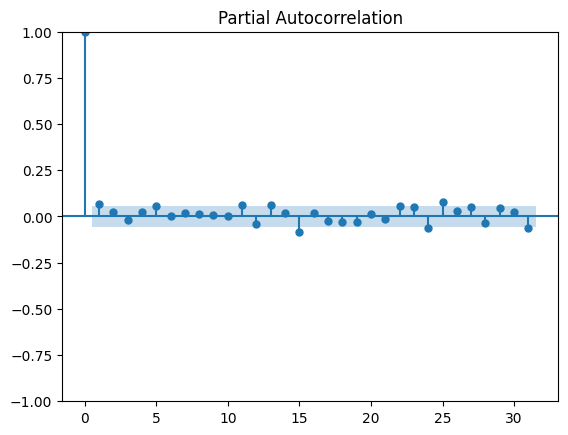

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t)

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model_arima = ARIMA(r_t, order=(2, 0, 2))  # ARIMA(p,d,q) parameters
model_fit = model_arima.fit()

# Print the summary of the ARIMA model fit
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1206
Model:                 ARIMA(2, 0, 2)   Log Likelihood                2468.400
Date:                Wed, 13 Nov 2024   AIC                          -4924.799
Time:                        15:30:18   BIC                          -4894.229
Sample:                             0   HQIC                         -4913.286
                               - 1206                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.060      0.289      -0.001       0.003
ar.L1          0.6340      0.955      0.664      0.507      -1.237       2.505
ar.L2         -0.3371      0.322     -1.046      0.2

In [21]:
def _arima_fit(orders, data):
  models = dict()
  for order in orders:
    model = ARIMA(data, order = order).fit()
    model_name = 'ARIMA({},{},{})'.format(order[0], order[1], order[2])
    print('{} --> AIC={}; BIC={}'.format(model_name, model.aic, model.bic))
    models[model_name] = model
  return models

orders = [(1, 0, 1), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
models = _arima_fit(orders, r_t)

ARIMA(1,0,1) --> AIC=-4929.526250689229; BIC=-4909.14599318008
ARIMA(1,0,0) --> AIC=-4931.022363610652; BIC=-4915.737170478791
ARIMA(1,0,0) --> AIC=-4931.022363610652; BIC=-4915.737170478791
ARIMA(0,0,1) --> AIC=-4930.723906280578; BIC=-4915.438713148717


In [27]:
pip install numpy==1.24.3

     ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
     --------------- ------------------------ 4.2/10.9 MB 27.9 MB/s eta 0:00:01
     --------------------------------------- 10.9/10.9 MB 29.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "c:\Users\hien0\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\hien0\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\hien0\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
        File "c:\Users\hien0\AppData\Local\Programs\Python\Python312\Lib\si

In [28]:
pip install --upgrade pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
pip show numpy

Name: numpy
Version: 2.1.3
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are
 met:

     * Redistributions of source code must retain the above copyright
        notice, this list of conditions and the following disclaimer.

     * Redistributions in binary form must reproduce the above
        copyright notice, this list of conditions and the following
        disclaimer in the documentation and/or other materials provided
        with the distribution.

     * Neither the name of the NumPy Developers nor the names of any
        contributors may be used to endorse or promote products derived
        from this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED

In [30]:
pip show pmdarima

Name: pmdarimaNote: you may need to restart the kernel to use updated packages.

Version: 2.0.4
Summary: Python's forecast::auto.arima equivalent
Home-page: http://alkaline-ml.com/pmdarima
Author: 
Author-email: 
License: MIT
Location: c:\Users\hien0\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: Cython, joblib, numpy, packaging, pandas, scikit-learn, scipy, setuptools, statsmodels, urllib3
Required-by: 


In [1]:
import pmdarima

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
!pip install pmdarima


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from statsmodels.tsa.arima_model import ARIMA

In [5]:

import pmdarima as pm

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject